In [1]:
import matplotlib.pyplot as plt
plt.style.use('../../note.mplstyle')
import numpy as np

In [2]:
from qutip import *

# Unit system

Let $R \equiv [\Delta_{0}^{2} + \Delta_{1}^{2} + (J/\hbar)^{2}]^{1/2}$

- The unit of energy : $\hbar R$
- The unit of frequency : $R$

In [3]:
from numpy import pi, cos, sin

In [4]:
theta_arr = np.linspace(0, pi/2.,3)
N_theta = theta_arr.size

phi_arr = np.linspace(0,pi/2.,4)
N_phi = phi_arr.size

In [5]:
del0_mesh = np.multiply.outer(sin(theta_arr), cos(phi_arr))
del1_mesh = np.multiply.outer(sin(theta_arr), sin(phi_arr))
J_mesh = np.multiply.outer(cos(theta_arr), np.ones_like(phi_arr))

In [6]:
del0_mesh.shape

(3, 4)

In [7]:
# dels_mesh = np.empty()
dels_mesh = np.stack((del0_mesh,del1_mesh))

In [8]:
dels_mesh.shape

(2, 3, 4)

In [9]:
# dels_mesh[(0)]

In [10]:
Omega0_mesh = np.abs(del0_mesh - 2.*J_mesh)

In [11]:
Omega1 = 0.

In [12]:
options = Options(nsteps=20000)

In [13]:
del0_mesh

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.07106781e-01, 6.12372436e-01, 3.53553391e-01, 4.32978028e-17],
       [1.00000000e+00, 8.66025404e-01, 5.00000000e-01, 6.12323400e-17]])

In [14]:
zero = Qobj(np.zeros((2,2)))

I, sigx, sigy, sigz = identity(2), sigmax(), sigmay(), sigmaz()

sigz_0 = tensor([sigz,I])
sigz_1 = tensor([I,sigz])
sigzlist = [sigz_0, sigz_1]

sigx_0 = tensor([sigx,I])
sigx_1 = tensor([I,sigx])
sigxlist = [sigx_0, sigx_1]

sigzsigz = tensor(sigz,sigz)

In [15]:
N = 2

In [16]:
# params = (f"-{wmw[1]:.4g}-wR0-{wR[0]:.4g}-wR1-{wR[1]:.4g}-J-{J:.4g}-tmax-{tmax}")
# params

In [17]:
params = f"Omega0-resonant-E01-E11_Omega1-zero"
params

'Omega0-resonant-E01-E11_Omega1-zero'

In [18]:
# state_t0 = (1/2**0.5) * basis(2,1) + (1/2**0.5) * basis(2,0)

#  = ket2dm(state_t0)

In [19]:
(1/2**0.5) * tensor([basis(2,1), basis(2,1)]) 
+ (1/2**0.5) * tensor([basis(2,0), basis(2,0)])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]]

In [20]:
ket_11 = tensor([basis(2,0), basis(2,0)])
ket_01 = tensor([basis(2,1), basis(2,0)])

ket_01_plus_11 = (1/2**0.5) * ket_11 + (1/2**0.5) * ket_01

In [21]:
ket_00 = tensor([basis(2,1), basis(2,1)])

In [22]:
ket_00_plus_11 = (1/2**0.5) * ket_00 + (1/2**0.5) * ket_11

In [23]:
rho_00_plus_11 = ket2dm(ket_00_plus_11)

In [24]:
rho_00_plus_11

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

In [25]:
ket_01_plus_11.norm()

0.9999999999999999

In [26]:
ket_00_plus_11.norm()

0.9999999999999999

In [27]:
# ket2dm(tensor([basis(2,1),basis(2,0)]))

In [28]:
c_ops = []

In [29]:
tmax = 10 # 100
t = np.linspace(0,tmax,201)

In [30]:
rho_01_plus_11 = ket2dm(ket_01_plus_11)

In [31]:
# def fidel(_, rho):
#     fidelity(rho)

In [32]:
fidel_00_plus_11 = lambda t, rho: np.real(fidelity(rho_00_plus_11, rho))

In [33]:
np.arange(24).reshape(2,3,4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [34]:
np.arange(24).reshape(2,3,4)[:,(1,2)]

array([[[ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [35]:
fidel_00_plus_11_t_mesh = np.empty((N_theta, N_phi, t.size), dtype=np.float64)

for indices in np.ndindex((N_theta, N_phi)):
#     print(j_theta, j_phi)
    j_theta, j_phi = indices
#     print(del0_mesh[indices])
    dels = dels_mesh[:,j_theta,j_phi]
    J = J_mesh[indices]
    wR = [Omega0_mesh[indices], Omega1]
    
    H0 = tensor([zero,zero])
    for j in range(N):
        H0 += dels[j] * (sigzlist[j]/2.)
    H0 += (- J) * sigzsigz

    Hdrive = tensor([zero,zero])
    for j in range(N):
        Hdrive += wR[j] * (sigxlist[j]/2.)
        
    H = H0 + Hdrive
    
    res = mesolve(H, rho_01_plus_11, t, c_ops, fidel_00_plus_11, options=options)
    fidel_00_plus_11_t_mesh[j_theta,j_phi,:] = res.expect
#     print(indices, res.expect)

In [36]:
fidel_00_plus_11_t_mesh.shape

(3, 4, 201)

In [37]:
fidel_00_plus_11_mesh_max_t = np.max(fidel_00_plus_11_t_mesh, axis=-1)

In [38]:
fidel_00_plus_11_mesh_max_t

array([[0.5       , 0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       ],
       [0.70708756, 0.70710425, 0.70710553, 0.5       ]])

In [39]:
from ultrashort.plot import color_meshes_from_arrays

In [40]:
phi_over_pi_cmesh, theta_over_pi_cmesh = color_meshes_from_arrays(phi_arr/pi, theta_arr/pi)

In [41]:
N_theta

3

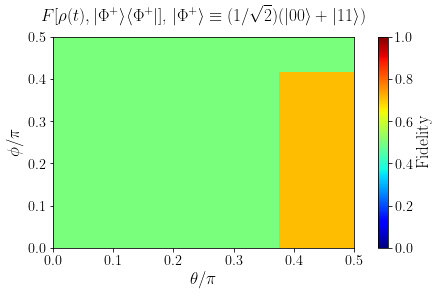

In [43]:
fig, ax = plt.subplots(constrained_layout=True)
pcm = ax.pcolormesh(theta_over_pi_cmesh, phi_over_pi_cmesh, 
                    fidel_00_plus_11_mesh_max_t, vmax=1, vmin=0, cmap='jet')
ax.set_xlabel(r"$\theta / \pi$")
ax.set_ylabel(r"$\phi / \pi$")
cb = fig.colorbar(pcm, ax=ax)
cb.set_label(r"Fidelity")
ax.set_title(r"$F[\rho(t),|\Phi^{+}\rangle\langle\Phi^{+}|]$"
             r", $|\Phi^{+}\rangle \equiv (1/\sqrt{2})(|00\rangle+|11\rangle)$", pad=15)
# fig.savefig("fidelity-00-plus-11-from-01-plus-11-test-003.png")